# Stree view house number

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.plots import *
import pandas as pd
from fastai.conv_learner import *
from fastai.dataset import *

In [3]:
ls /fast/data/SVHN

extra/            models/          test.tar.gz      train_length.csv
extra_boxes.csv   test/            tmp/             train.tar.gz
extra.csv         test_boxes.csv   train/
extra_length.csv  test.csv         train_boxes.csv
extra.tar.gz      test_length.csv  train.csv


In [4]:
home_dir = '/fast/data/SVHN/'

In [5]:
train_df = pd.read_csv(os.path.join(home_dir, 'test.csv'))

In [6]:
max([len(l.split(' ')) for l in list(train_df.tags)])

5

In [7]:
train_df.sample(3)

,image_name,tags
2877,12588,3 6
1950,11753,7 1
12805,9762,4


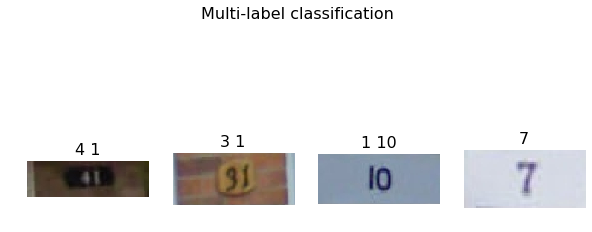

In [8]:
samples = train_df.sample(4)
list_paths = [f"{home_dir}test/{i}.png" for i in list(samples['image_name'])]
titles=list(samples['tags'])
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [9]:
f_model = resnet18

In [10]:
label_csv = os.path.join(home_dir, 'test.csv')
bb_csv = os.path.join(home_dir, 'test_boxes.csv')
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [11]:
train_df = pd.read_csv(label_csv)
train_df['tags'] = train_df.tags.apply(lambda x: [float(i) for i in x.split(' ')])

In [12]:
((val_label,trn_label),) = split_by_idx(val_idxs, train_df)

In [13]:
def get_data(sz, bs=30):
    # don't use data augumented in test set.
    aug_tfms = []
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
    return ImageClassifierData.from_csv(home_dir, 'test', bb_csv, tfms=tfms, bs=bs, 
                                        suffix='.png', test_name='test', 
                                        continuous=True, num_workers=4)

In [14]:
sz = 256
data = get_data(sz)

In [15]:
x, y = data.trn_ds[0]

In [16]:
x.shape, y

((3, 256, 256),
 array([ 89.,  48., 180.,  64.,  89.,  77., 180., 108.], dtype=float32))

In [17]:
from matplotlib import patches, patheffects
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def get_big_bounding_box(boxes):
    # top, left, bottom, right
    return np.array([min(boxes[:, 0]), min(boxes[:,1]), max(boxes[:, 2]), max(boxes[:, 3])])

def draw_im(im, boxes, cats, draw_one_box=False):
    ax = show_img(im, figsize=(8,4))
    if draw_one_box:
        b = bb_hw(boxes)
        draw_rect(ax, b)
    else:
        for b, c in zip(boxes, cats):
            b = bb_hw(b)
            draw_rect(ax, b)
            draw_text(ax, b[:2], c, sz=16)

In [18]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, labels, sz):
        self.ds,self.labels = ds,labels
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        boxes = y.reshape((-1, 4))
        box = get_big_bounding_box(boxes) / sz
        return (x, ((len(self.labels[i])-1), box))

In [19]:
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
data.trn_dl.dataset = trn_ds2

In [20]:
x, y = data.trn_ds[4]
print(x.shape, y)

(3, 256, 256) (1, array([0.40625, 0.45703, 0.76172, 0.55859], dtype=float32))


(2, array([0.24609, 0.32812, 0.76953, 0.53516], dtype=float32))


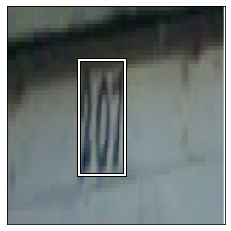

In [21]:
x, y = data.trn_ds[114]
img = data.trn_ds.ds.denorm(to_np(x))[0]
boxes = y[1] * sz
draw_im(img, boxes, y[1], draw_one_box=True)
print(y)

In [22]:
class CountHead(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.adaptive = AdaptiveConcatPool2d((1,1))
        self.flatten = Flatten()
        self.layer1 = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(n, 512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(512, 512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer31 = nn.Sequential(nn.Linear(512, 6))
        # apply sigmoid to make sure output in range [0..1]. 
        # This is the coordinates of the smallest box that corver all number.
        self.layer32 = nn.Sequential(nn.Linear(512, 4), nn.Sigmoid())
        
    def forward(self, x):
        out = self.adaptive(x)
        out = self.flatten(out)
        out = self.layer1(out)
        out = self.layer2(out)
        label = self.layer31(out)
        box = self.layer32(out)
        return [label, box] # output of the model are number of digit and the bounding box.

In [23]:
def custome_accuracy(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    input = input[0]
    targs = targs[0]
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [24]:
count_head = CountHead(1024)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=count_head)
learn = ConvLearner(data, models, metrics=[custome_accuracy])
learn.opt_fn = optim.Adam

In [25]:
NUMBER_INDEX = 2
N_NUMBER_INDEX= 0

In [26]:
# learn.crit = MSECustomize()

In [27]:
# learn.crit(pred, labels)

In [28]:
# learn.summary()

In [29]:
ls /fast/data/SVHN/models

svhn_001.h5                     svhn_number_002_pool3.h5
svhn_001_resnet32.h5            svhn_number_003.h5
svhn_002.h5                     svhn_number_003_num_boost.h5
svhn_002_resnet32.h5            svhn_number_003_pool2_extra.h5
svhn_003.h5                     svhn_number_003_pool2.h5
svhn_003_resnet32.h5            svhn_number_003_pool3.h5
svhn_box_001.h5                 svhn_number_004.h5
svhn_box_002.h5                 svhn_number_004_num_boost.h5
svhn_box_003.h5                 svhn_number_004_pool2_extra.h5
svhn_box_004.h5                 svhn_number_004_pool2.h5
svhn_number_001.h5              svhn_number_004_pool3.h5
svhn_number_001_pool2.h5        svhn_number_005.h5
svhn_number_001_pool3.h5        svhn_number_005_num_boost.h5
svhn_number_002.h5              svhn_number_005_pool2.h5
svhn_number_002_pool2_extra.h5  svhn_number_005_pool3.h5
svhn_number_002_pool2.h5        tmp.h5


In [30]:
learn.load('svhn_box_004')

In [31]:
learn.model.eval()
wrong_images = []
total_sample = 0
right_sample = 0
with torch.no_grad():
    data_iterator = iter(data.trn_dl)
    for i in range(100): # only run all 100 first batch to save mem
        images, labels = next(data_iterator)
        pred = learn.model(images)
        n_digits = pred[0].argmax(dim=1)
        mark = n_digits == labels[0]
        total_sample += len(mark)
        right_sample += (mark == 1).float().sum()
        # comment this for loop to save memory if you only want to calculate accuracy.
        for i in range(len(mark)):
            if mark[i] == 0:
                wrong_images.append((images[i], n_digits[i], pred[1][i], labels[0][i]))

In [32]:
print("Accuracy on test set: ", (right_sample/total_sample).item())

Accuracy on test set:  0.8296666741371155


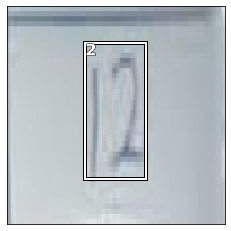

In [51]:
import random
i = random.randint(0, len(wrong_images)-1)
image, pred, box, true_num = wrong_images[i]
img = data.trn_ds.ds.denorm(to_np(image))[0]
draw_im(img, [np.array(box.tolist()) * sz], [pred.tolist()])

In [34]:
# Bounding boxes are very good. They corever all number.
# Many wrong cases have very small numbers. We will improve it in tutorial 004